# Práctica 1. Aprendizaje Automático

Authors: Carlos Iborra Llopis (100451170), Alejandra Galán Arrospide (100451273)


# 0. Table of contents

- [Práctica 1. Aprendizaje Automático](#práctica-1-aprendizaje-automático)
  - [0. Table of contents](#0-table-of-contents)
  - [1. Requirements](#1-requirements)
  - [2. Reading the datasets](#2-reading-the-datasets)


# 1. Requirements


In [2]:
""" Importing necessary libraries """
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import scipy.stats as st
import scipy


# 2. Reading the datasets

Reading the datasets from the bz2 files, group 2.


In [3]:
""" Reading the dataset """
disp_df = pd.read_csv("../data/disp_st2ns1.txt.bz2",
                      compression="bz2", index_col=0)
comp_df = pd.read_csv("../data/comp_st2ns1.txt.bz2",
                      compression="bz2", index_col=0)


# 3. EDA


**Key Concepts of Exploratory Data Analysis**

- **2 types of Data Analysis**
  - Confirmatory Data Analysis
  - Exploratory Data Analysis
- **4 Objectives of EDA**
  - Discover Patterns
  - Spot Anomalies
  - Frame Hypothesis
  - Check Assumptions
- **2 methods for exploration**
  - Univariate Analysis
  - Bivariate Analysis
- **Stuff done during EDA**
  - Trends
  - Distribution
  - Mean
  - Median
  - Outlier
  - Spread measurement (SD)
  - Correlations
  - Hypothesis testing
  - Visual Exploration


## 3.1. Dataset description

- **apcp_sfc**: 3-Hour accumulated precipitation at the surface (kg·m⁽⁻²⁾)
- **dlwrf_sfc**: Downward long-wave radiative flux average at the surface (W·m⁽⁻²⁾)
- **dswrf_sfc**: Downward short-wave radiative flux average at the surface (W·m⁽⁻²⁾)
- **pres_msl**: Air pressure at mean sea level (Pa)
- **pwat_eatm**: Precipitable Water over the entire depth of the atmosphere (kg·m⁽⁻²⁾)
- **spfh_2m**: Specific Humidity at 2 m above ground (kg·kg⁽⁻¹⁾)
- **tcdc_eatm**: Total cloud cover over the entire depth of the atmosphere (%)
- **tcolc_eatm**: Total column-integrated condensate over the entire atmos. (kg·m⁽⁻²⁾)
- **tmax_2m**: Maximum Temperature over the past 3 hours at 2 m above the ground (K)
- **tmin_2m**: Mininmum Temperature over the past 3 hours at 2 m above the ground (K)
- **tmp_2m**: Current temperature at 2 m above the ground (K)
- **tmp_sfc**: Temperature of the surface (K)
- **ulwrf_sfc**: Upward long-wave radiation at the surface (W·m⁽⁻²⁾)
- **ulwrf_tatm**: Upward long-wave radiation at the top of the atmosphere (W·m⁽⁻²⁾)
- **uswrf_sfc**: Upward short-wave radiation at the surface (W·m⁽⁻²⁾)


In [4]:
disp_df.describe()


,apcp_sf1_1,apcp_sf2_1,apcp_sf3_1,apcp_sf4_1,apcp_sf5_1,dlwrf_s1_1,dlwrf_s2_1,dlwrf_s3_1,dlwrf_s4_1,dlwrf_s5_1,...,ulwrf_t2_1,ulwrf_t3_1,ulwrf_t4_1,ulwrf_t5_1,uswrf_s1_1,uswrf_s2_1,uswrf_s3_1,uswrf_s4_1,uswrf_s5_1,salida
count,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,...,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4.380000e+03
mean,0.606809,0.252764,0.480446,0.271476,0.514641,316.698532,317.381851,324.682998,343.757513,343.097254,...,247.300145,251.597699,261.916025,260.870143,0.076235,38.585222,76.064674,126.504047,99.087049,1.629826e+07
std,2.275740,0.999809,1.774720,1.086599,1.886735,55.637609,57.874376,58.702133,60.860672,60.693451,...,36.804219,36.382653,39.190955,38.734023,0.255491,25.984861,30.784078,40.571154,35.454368,7.965298e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,158.971770,160.032903,165.524543,183.671312,186.342961,...,113.559602,118.679132,119.393449,121.951425,0.000000,0.000000,3.181818,4.363636,2.545455,5.100000e+05
25%,0.000000,0.000000,0.000000,0.000000,0.000000,271.219564,268.889864,275.709318,293.757163,292.834810,...,230.482578,233.976283,245.721419,243.850282,0.000000,14.000000,53.431818,108.454545,74.795455,1.062375e+07
50%,0.000000,0.000000,0.000000,0.000000,0.000000,321.106932,323.063311,329.708327,346.763388,345.883918,...,253.309217,257.270334,270.790095,269.300432,0.000000,35.363636,79.272727,135.909091,104.818182,1.635690e+07
75%,0.109091,0.051818,0.127500,0.036364,0.090909,366.145476,370.147353,378.509126,399.600853,398.728281,...,274.861445,278.800420,290.139446,289.699652,0.000000,61.818182,102.727273,155.204545,129.545455,2.312775e+07
max,43.009090,16.846364,28.399091,26.381818,36.875455,426.173970,427.486894,429.693146,455.566337,453.910406,...,311.991660,315.569164,328.920274,327.253141,1.000000,92.272727,192.636364,450.636364,313.909091,3.122700e+07


In [5]:
disp_df.shape


(4380, 76)

In [6]:
disp_df.head()


,apcp_sf1_1,apcp_sf2_1,apcp_sf3_1,apcp_sf4_1,apcp_sf5_1,dlwrf_s1_1,dlwrf_s2_1,dlwrf_s3_1,dlwrf_s4_1,dlwrf_s5_1,...,ulwrf_t2_1,ulwrf_t3_1,ulwrf_t4_1,ulwrf_t5_1,uswrf_s1_1,uswrf_s2_1,uswrf_s3_1,uswrf_s4_1,uswrf_s5_1,salida
V1,0.0,0.0,0.0,0.000000,0.0,268.583582,244.241641,251.174486,269.741308,268.377441,...,252.504475,254.760271,263.342404,260.067843,0.0,10.000000,50.000000,106.636364,72.000000,11930700
V2,0.0,0.0,0.0,0.008182,0.2,251.725869,255.824126,272.163913,318.259924,307.929083,...,233.458263,233.027276,212.652054,222.052916,0.0,8.181818,35.909091,58.181818,42.090909,9778500
V3,0.0,0.0,0.0,0.000000,0.0,219.734547,211.996022,216.405820,235.529123,239.840132,...,232.828737,235.480750,245.177331,238.893102,0.0,10.272727,55.272727,118.454545,79.181818,9771900
V4,0.0,0.0,0.0,0.000000,0.0,253.499410,230.896544,235.857221,240.274556,237.804048,...,241.916776,243.398572,251.473036,247.503769,0.0,8.909091,46.000000,107.090909,73.636364,6466800
V5,0.0,0.0,0.0,0.000000,0.0,234.890020,238.927051,246.850822,271.577246,275.572826,...,233.706659,239.952805,258.128188,253.200684,0.0,8.909091,48.909091,106.272727,71.818182,11545200


In [7]:
result = disp_df.eq(0.0).sum()/len(disp_df)*100

# select only results over 50.0
result = result[result > 30.0]
result = result.sort_values(ascending=False)
result


dswrf_s1_1    92.054795
uswrf_s1_1    90.844749
apcp_sf4_1    63.378995
apcp_sf5_1    61.278539
apcp_sf1_1    61.164384
apcp_sf2_1    60.296804
apcp_sf3_1    57.305936
tcdc_ea3_1    37.945205
tcdc_ea1_1    37.237443
tcdc_ea2_1    37.123288
tcdc_ea5_1    36.004566
tcdc_ea4_1    35.547945
dtype: float64

In [8]:
disp_df.isna().sum()


apcp_sf1_1    0
apcp_sf2_1    0
apcp_sf3_1    0
apcp_sf4_1    0
apcp_sf5_1    0
             ..
uswrf_s2_1    0
uswrf_s3_1    0
uswrf_s4_1    0
uswrf_s5_1    0
salida        0
Length: 76, dtype: int64

In [9]:
disp_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4380 entries, V1 to V4380
Data columns (total 76 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   apcp_sf1_1  4380 non-null   float64
 1   apcp_sf2_1  4380 non-null   float64
 2   apcp_sf3_1  4380 non-null   float64
 3   apcp_sf4_1  4380 non-null   float64
 4   apcp_sf5_1  4380 non-null   float64
 5   dlwrf_s1_1  4380 non-null   float64
 6   dlwrf_s2_1  4380 non-null   float64
 7   dlwrf_s3_1  4380 non-null   float64
 8   dlwrf_s4_1  4380 non-null   float64
 9   dlwrf_s5_1  4380 non-null   float64
 10  dswrf_s1_1  4380 non-null   float64
 11  dswrf_s2_1  4380 non-null   float64
 12  dswrf_s3_1  4380 non-null   float64
 13  dswrf_s4_1  4380 non-null   float64
 14  dswrf_s5_1  4380 non-null   float64
 15  pres_ms1_1  4380 non-null   float64
 16  pres_ms2_1  4380 non-null   float64
 17  pres_ms3_1  4380 non-null   float64
 18  pres_ms4_1  4380 non-null   float64
 19  pres_ms5_1  4380 non-null   fl

## 3.2. Missing values


### Observations

The variables with most ammount of zeros are:

- **dswrf_s1_1**: Downward short-wave radiative flux average at the surface, at 12:00 UTC, normal to have a lot of zeros as it is not sunny at 12:00
- **uswrf_s1_1**: Upward short-wave radiation at the surface, at 12:00 UTC, normal to have a lot of zeros as it is not sunny at 12:00
- **apcp_s**: 3-Hour accumulated precipitation at the surface, as it is not raining every day, it is normal to have a lot of zeros
- **tcdc_ea**: Total cloud cover over the entire depth of the atmosphere, as it is not cloudy every day, it is normal to have a lot of zeros


First, lets start by assigning the zeros to NaNs. By doing this we can visualize the varibles that take more values other than zero.


In [10]:
disp_df_nan = disp_df.replace(0.0, np.nan)


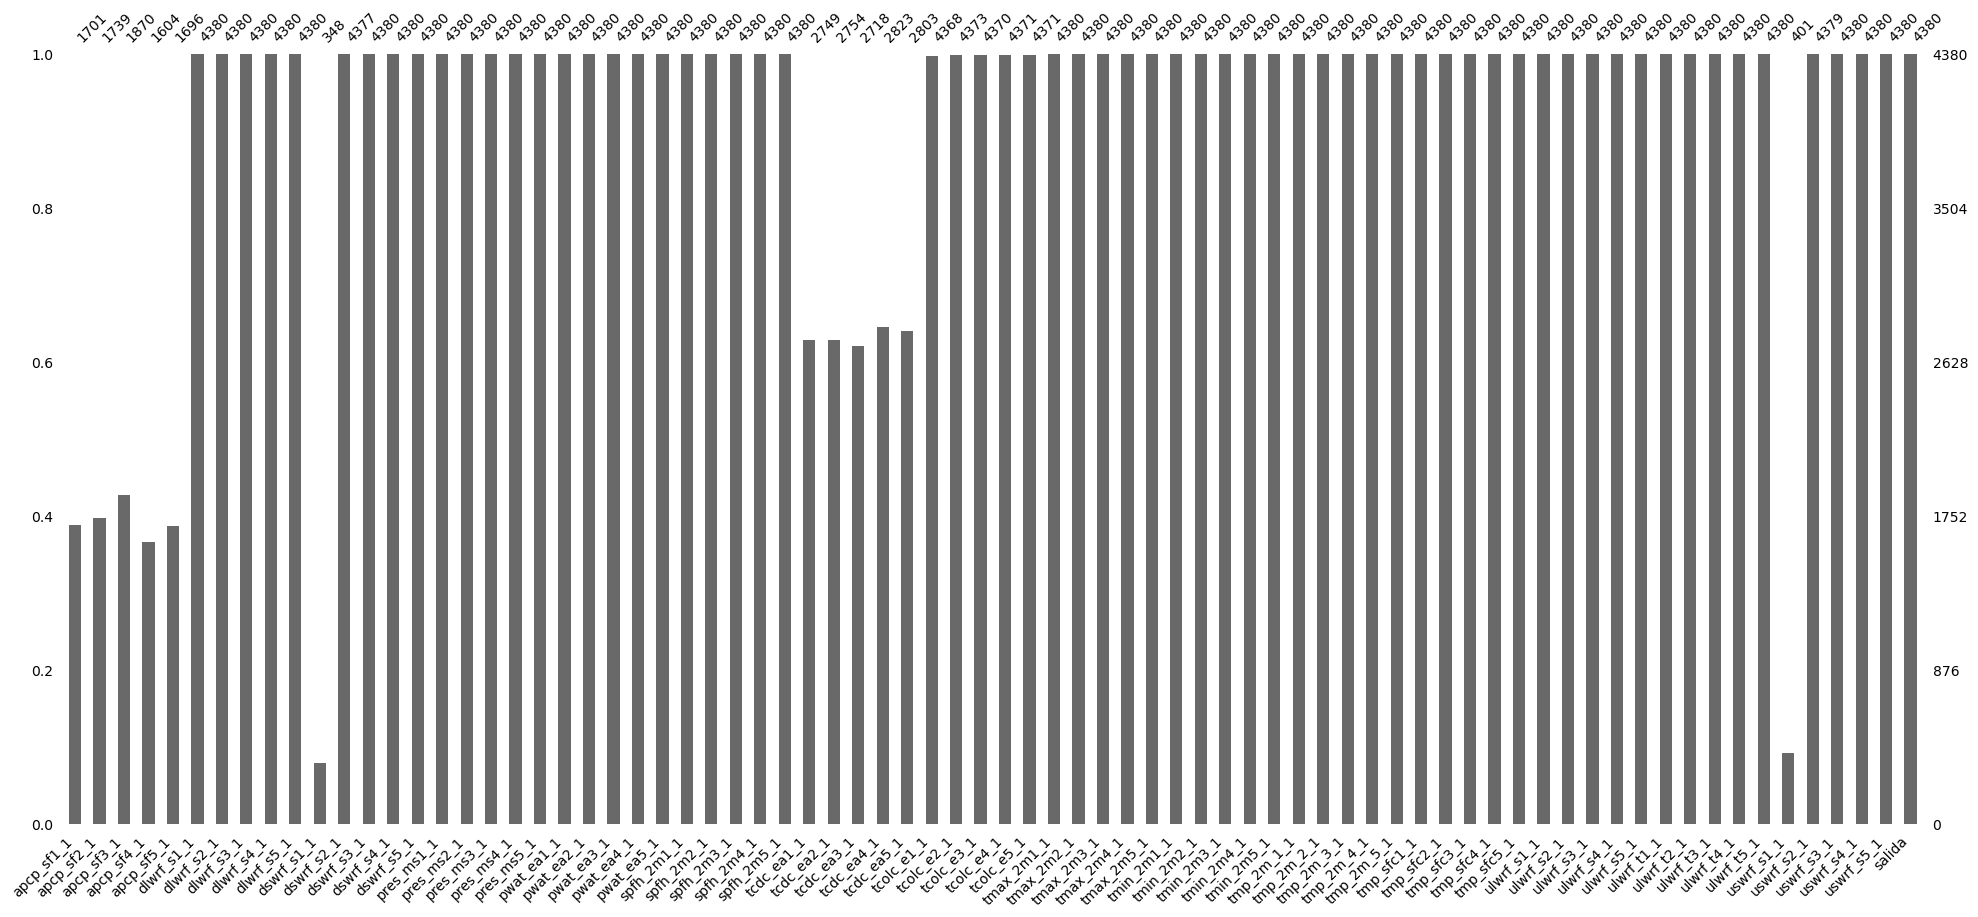

In [11]:
# Sustitute 0.0 values with NaN and plot the name of the columns with missing values
msno.bar(disp_df_nan, labels=True, fontsize=10)
# Exporting image as png to ../data/img folder
plt.savefig("../data/img/missing_values.png")


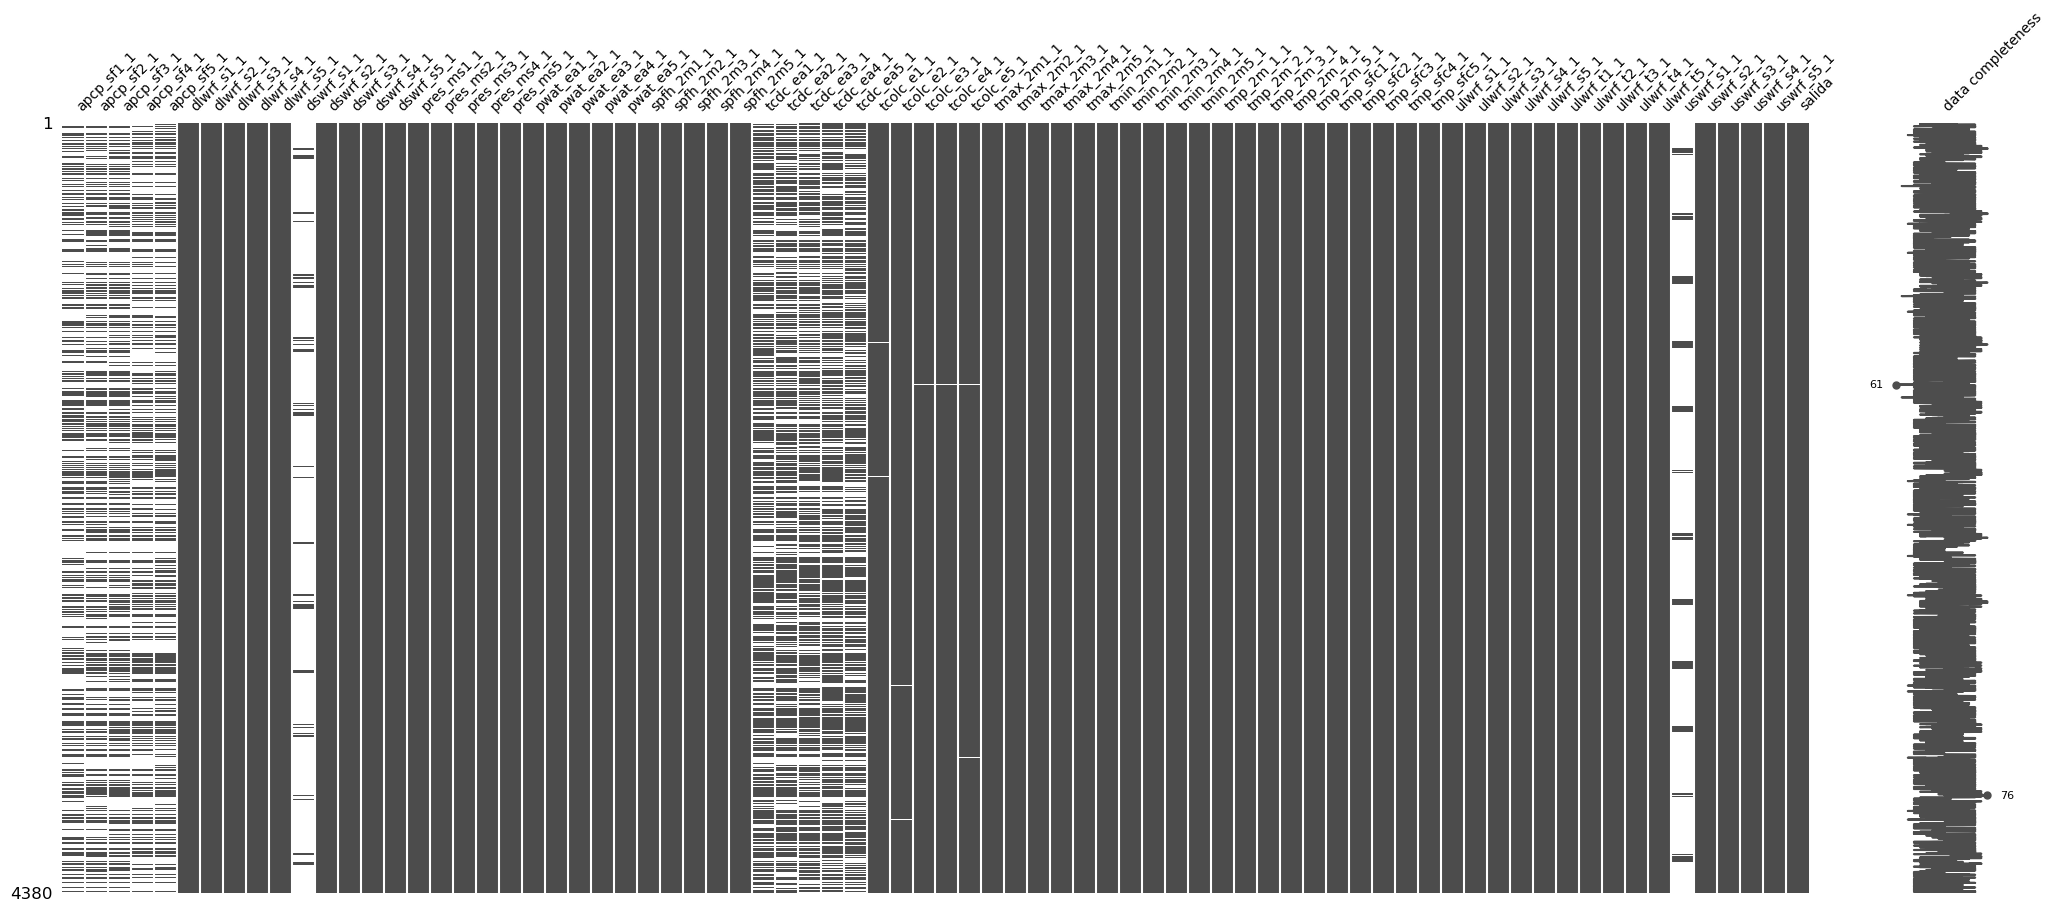

In [12]:
# """ Plotting the missing values in a matrix """
msno.matrix(disp_df_nan, labels=True, fontsize=10, color=(.3, .3, .3))
# # Exporting image as png to ../data/img folder
plt.savefig("../data/img/missing_values_matrix.png")


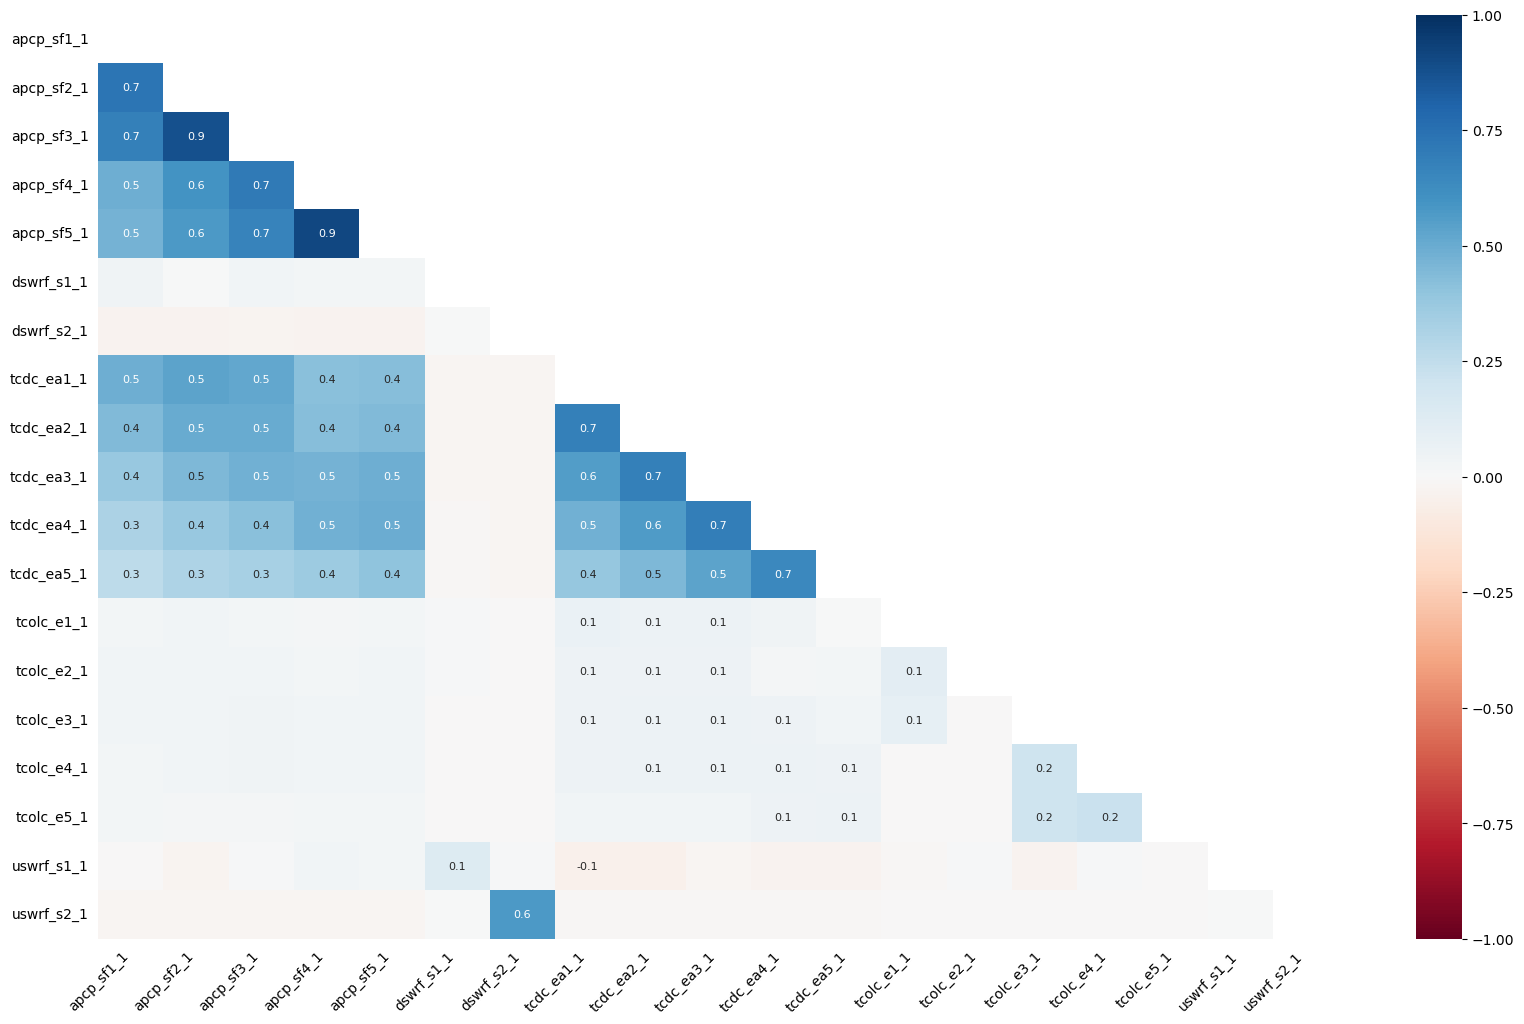

In [13]:
msno.heatmap(disp_df_nan, fontsize=10)
# Exporting image as png to ../data/img folder
plt.savefig("../data/img/missing_values_heatmap.png")


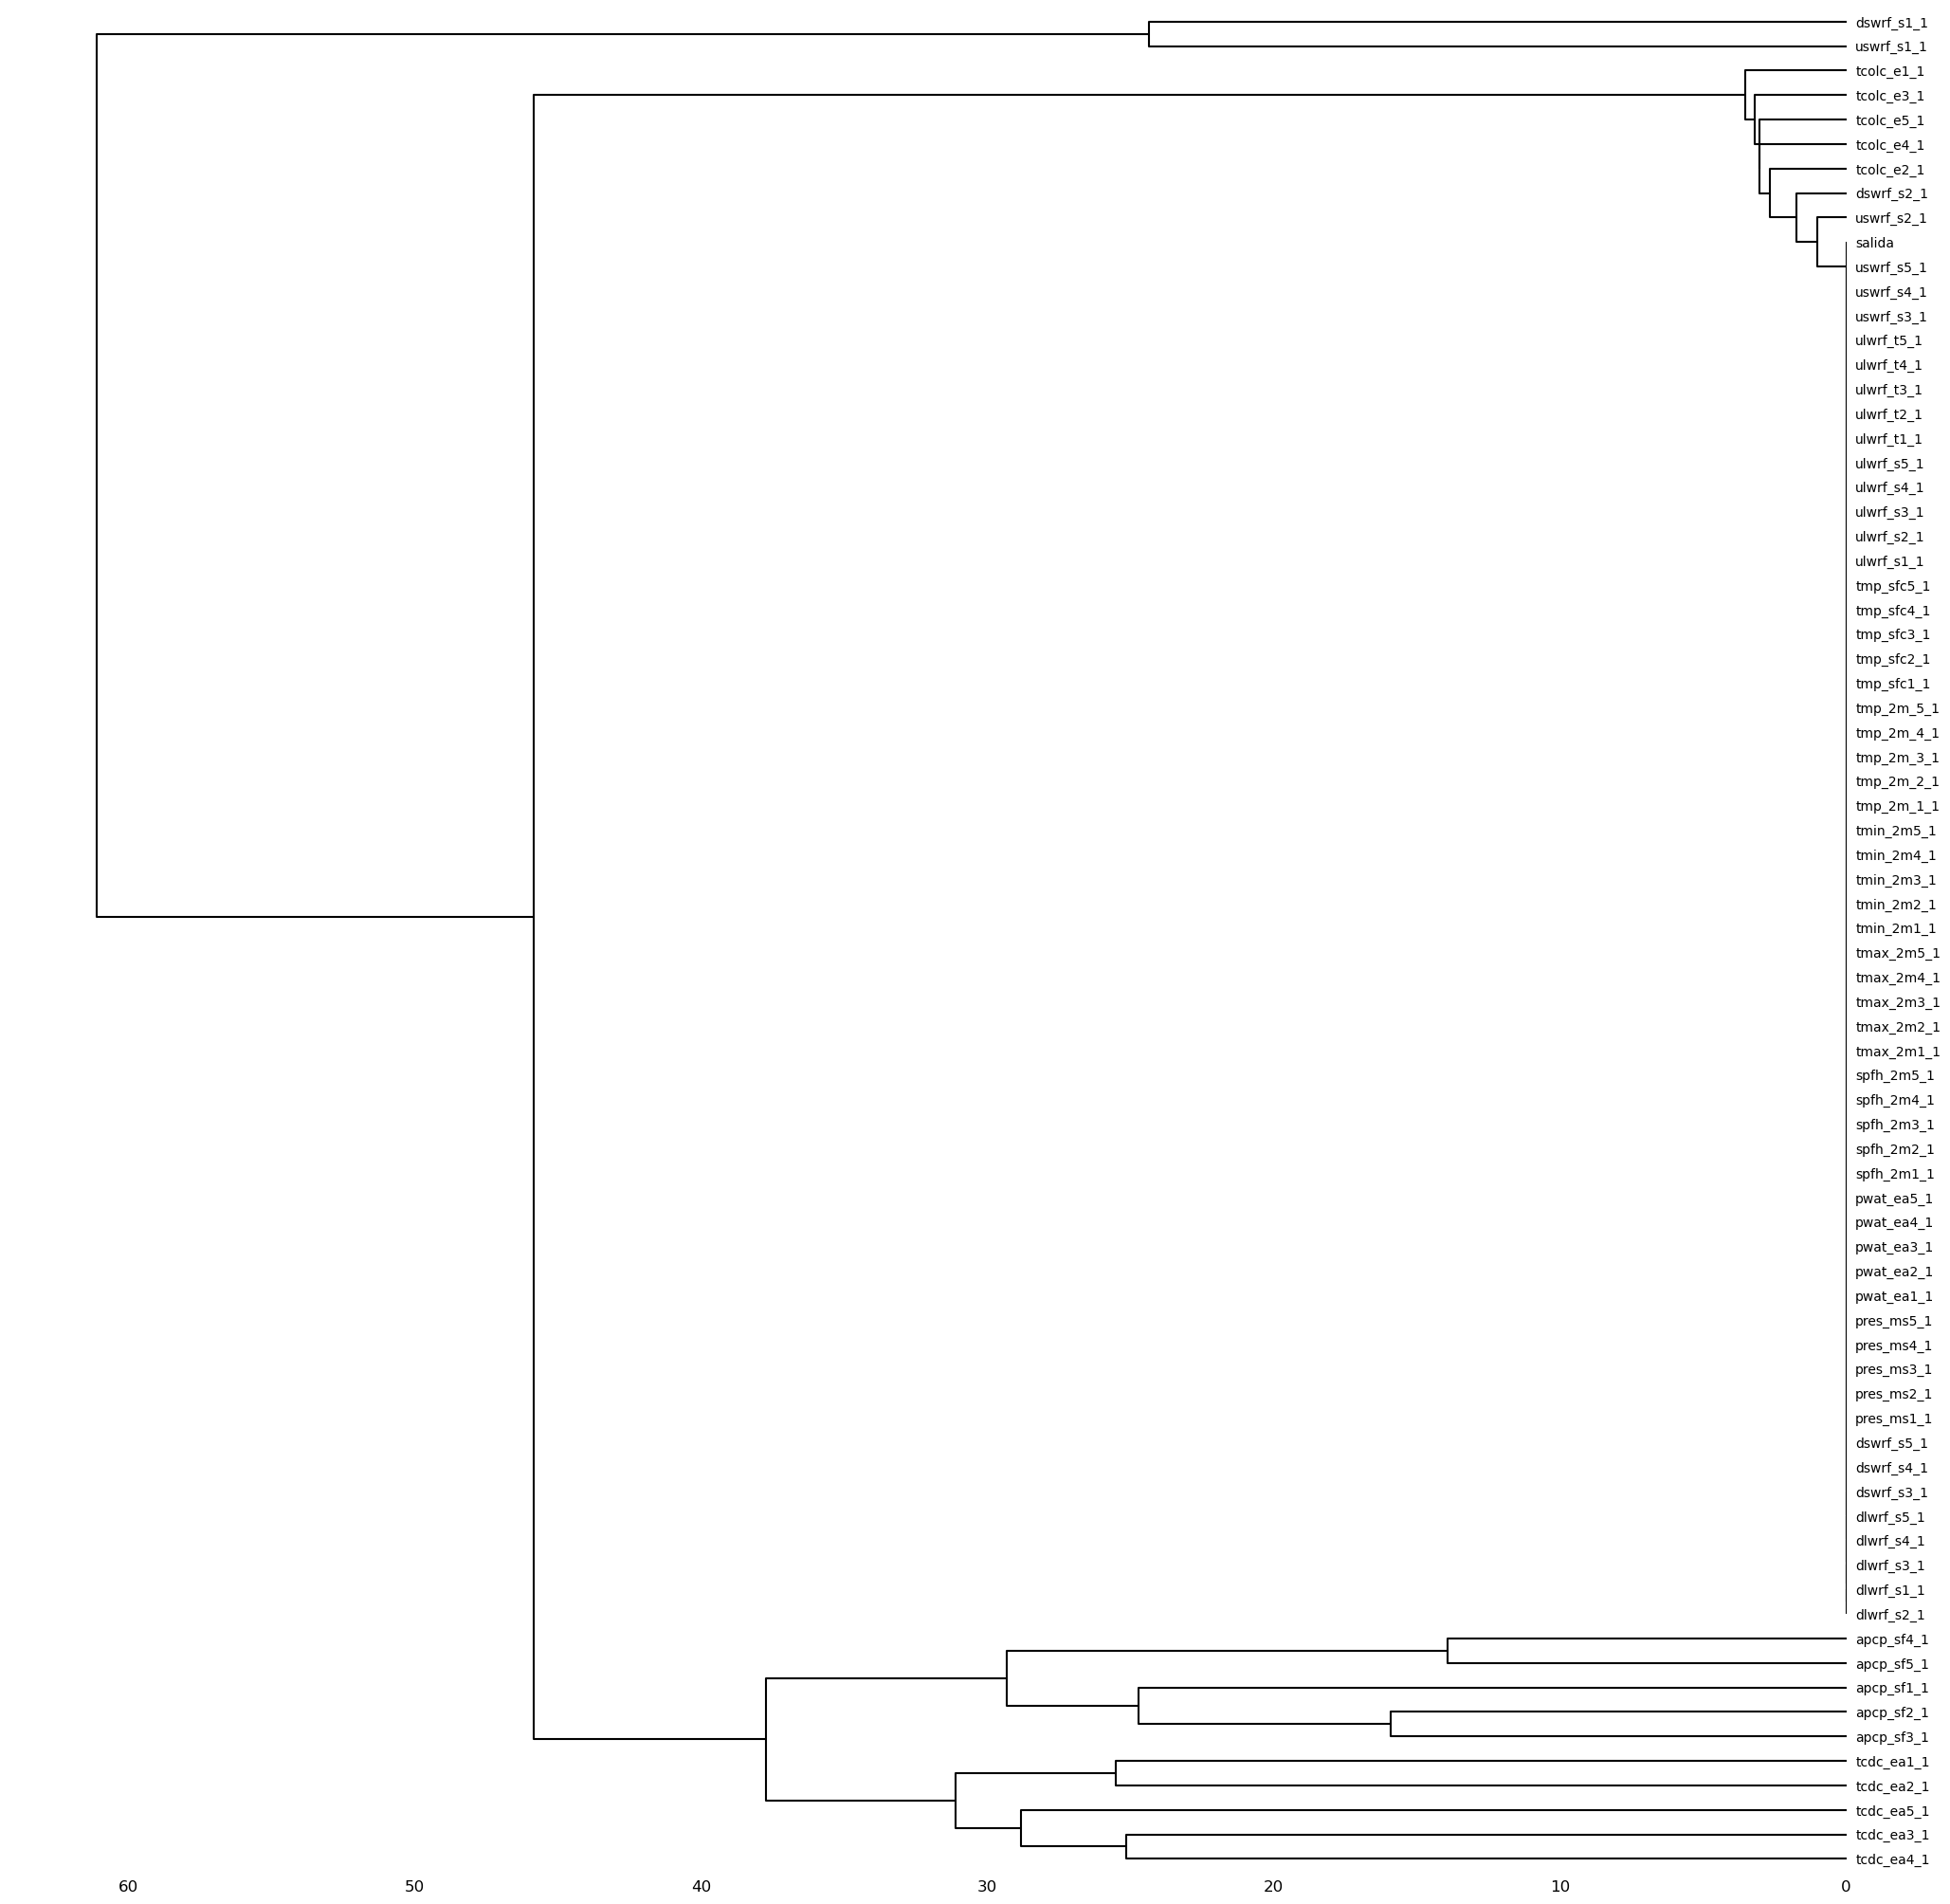

In [14]:
""" Plotting the dendrogram """
msno.dendrogram(disp_df_nan, fontsize=10)
# Exporting image as png to ../data/img folder
plt.savefig("../data/img/missing_values_dendrogram.png")


### Conclusion

In this section, we have come to the conclusion that the attributes that we suspected could have an important number of missing values (represented by 0), had instead valuable information. Since the data is clean and we have concluded there are no missing values, we do not need to complete them using a model or other methods and we can go to the next step, observing their correlation.


## 3.3. Outliers


In [15]:
# skewness: measure of the asymmetry of the probability distribution of a real-valued random variable about its mean.
disp_df.skew().sort_values(ascending=False)

apcp_sf4_1    9.232876
apcp_sf2_1    7.550050
apcp_sf1_1    7.402803
apcp_sf3_1    7.265894
apcp_sf5_1    7.195886
                ...   
ulwrf_t1_1   -0.965765
ulwrf_t3_1   -0.997749
ulwrf_t2_1   -1.007615
ulwrf_t5_1   -1.055472
ulwrf_t4_1   -1.181864
Length: 76, dtype: float64

In [16]:
# kurtosis: measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution.
disp_df.kurt().sort_values(ascending=False)

apcp_sf4_1    137.078212
apcp_sf1_1     78.306178
apcp_sf2_1     76.959166
apcp_sf5_1     76.901878
apcp_sf3_1     70.852519
                 ...    
uswrf_s2_1     -1.303016
spfh_2m2_1     -1.318701
spfh_2m5_1     -1.319063
dswrf_s2_1     -1.321058
spfh_2m3_1     -1.324692
Length: 76, dtype: float64

/home/carlosiborra/anaconda3/envs/ml_practica1_env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/carlosiborra/anaconda3/envs/ml_practica1_env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Log Normal'}, xlabel='apcp_sf4_1', ylabel='Density'>

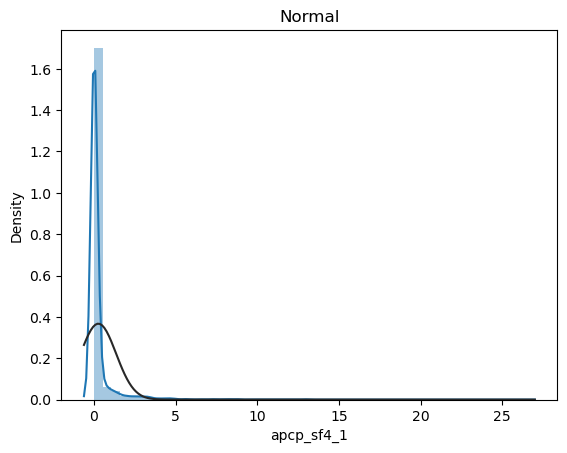

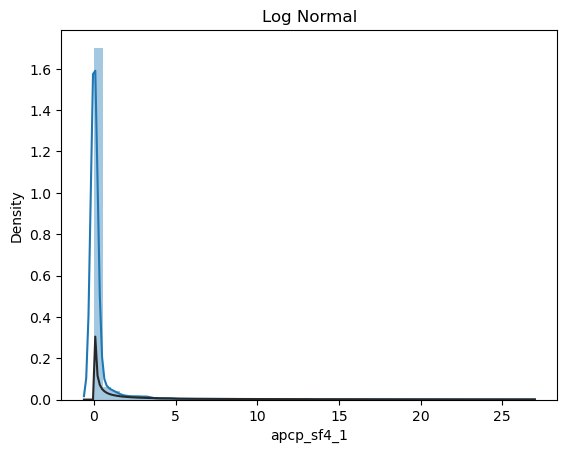

In [17]:
y = disp_df['apcp_sf4_1']
plt.figure(1); plt.title('Normal')
sns.distplot(y, kde=True, fit=st.norm)
plt.figure(2); plt.title('Log Normal')
sns.distplot(y, kde=True, fit=st.lognorm)

/home/carlosiborra/anaconda3/envs/ml_practica1_env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Skewness', ylabel='Density'>

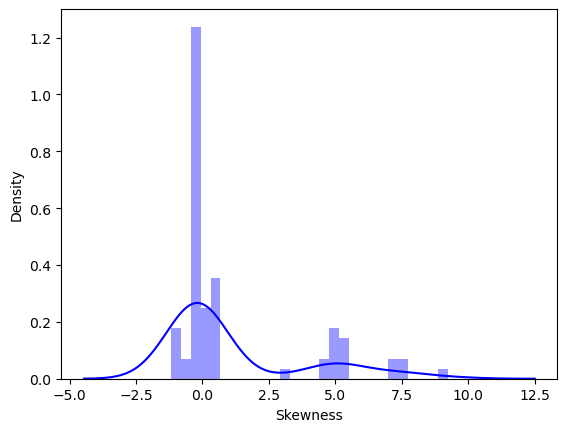

In [18]:
sns.distplot(disp_df.skew(),color='blue',axlabel ='Skewness')

/home/carlosiborra/anaconda3/envs/ml_practica1_env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


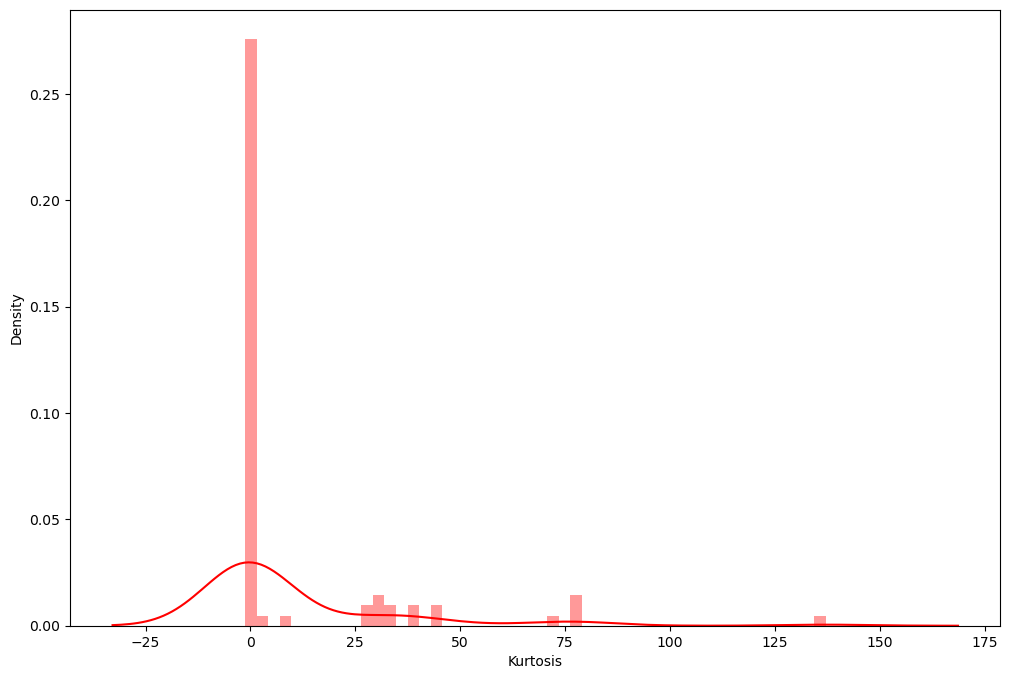

In [19]:
plt.figure(figsize = (12,8))
sns.distplot(disp_df.kurt(),color='r',axlabel ='Kurtosis',norm_hist= False, kde = True,rug = False)
#plt.hist(train.kurt(),orientation = 'vertical',histtype = 'bar',label ='Kurtosis', color ='blue')
plt.show()

## 3.4. Correlation


In [20]:
correlation = disp_df.corr()
correlation = abs(correlation)
print(correlation)  # 76 x 76 matrix of correlation values

            apcp_sf1_1  apcp_sf2_1  apcp_sf3_1  apcp_sf4_1  apcp_sf5_1  \
apcp_sf1_1    1.000000    0.587239    0.509665    0.249329    0.255535   
apcp_sf2_1    0.587239    1.000000    0.926354    0.394384    0.379884   
apcp_sf3_1    0.509665    0.926354    1.000000    0.574310    0.533648   
apcp_sf4_1    0.249329    0.394384    0.574310    1.000000    0.928523   
apcp_sf5_1    0.255535    0.379884    0.533648    0.928523    1.000000   
...                ...         ...         ...         ...         ...   
uswrf_s2_1    0.161360    0.204639    0.212301    0.135941    0.148588   
uswrf_s3_1    0.228271    0.313188    0.343573    0.252657    0.272716   
uswrf_s4_1    0.181360    0.279789    0.340832    0.350630    0.371776   
uswrf_s5_1    0.145594    0.235880    0.291234    0.309841    0.335141   
salida        0.171532    0.248745    0.282336    0.249886    0.275859   

            dlwrf_s1_1  dlwrf_s2_1  dlwrf_s3_1  dlwrf_s4_1  dlwrf_s5_1  ...  \
apcp_sf1_1    0.252467    0.2294

## IMPRIMIR LA LISTA DE VARIABLES CON CORRELACIONES MAYORES DE 0.95

In [97]:

correlation_list = []
iter = 0

for column in disp_df:
    correlation[column] = abs(correlation[column])
    mask = correlation[column] > 0.95
    print(correlation[column][mask].sort_values(ascending = False))
    
    # correlation_list.append(correlation[column][mask].sort_values(ascending = False).index.tolist())
    # correlation_list_dicts.append(correlation[column][mask].sort_values(ascending = False).to_dict())
    
    # añadimos los valores de correlacion a una lista de listas, que contiene los nombres de las columnas correladas y su indice de correlacion
    # se ha separado en 3 partes para hacer una comprension mas facil y para poder añadir el nombre de la columna que estamos analizando
    # * la primera parte añade el nombre de la columna que estamos analizando
    # * la segunda parte añade el nombre de las columnas correladas (a excepcion de la columna que estamos analizando) > 0.95
    # * la tercera parte añade el indice de correlacion de las columnas correladas (a excepcion de la columna que estamos analizando) > 0.95
    
    # First we need to create a dictionary with the column names and their correlation values (except the column we are analyzing)
    dict = ({key: value for key, value in correlation[column][mask].sort_values(ascending = False).to_dict().items() if key != column})
    print (dict)
    
    # Then we create a list of lists with the column names and their correlation values from the dictionary created above
    corr_list = [[key] + [value] for key, value in dict.items()]
    # Finally we add the name of the column we are analyzing to the list of lists created above as the first element of the list (str)
    corr_list.insert(0, f"Columna: {column}")
    print(corr_list)
    
    correlation_list += [corr_list]
    # almancenar la lista de correlaciones en una lista que contenga todas las correlaciones de la columna analizada a excepcion de ella misma
    # corr_list_index = correlation[column][mask].sort_values(ascending = False).index.tolist()
    # filtramos la lista anterior para que no contenga la columna que estamos analizando
    # corr_list_index = [x for x in corr_list_index if x != column]
    
    # corr_list_values = correlation[column][mask].sort_values(ascending = False).values.tolist()
    # corr_list_values = [x for x in corr_list_values if x != 1.0]
        
    # print(corr_list_index)
    # print(corr_list_values)
    
    # correlation_list.append([column] + [corr_list_index] + [correlation[column][mask].sort_values(ascending = False).values.tolist() if column != correlation[column][mask].sort_values(ascending = False).index.tolist() else []])
    # correlation_list.append(correlation[column][mask].sort_values(ascending = False).index.tolist() if column != correlation[column][mask].sort_values(ascending = False).index.tolist() else [])
    # correlation_list.append(correlation[column][mask].sort_values(ascending = False).values.tolist() if column != correlation[column][mask].sort_values(ascending = False).index.tolist() else [])
    # correlation_list.append([column] + [correlation[column][mask].sort_values(ascending = False).index.tolist() if column != correlation[column][mask].sort_values(ascending = False).index.tolist() else []] + [correlation[column][mask].sort_values(ascending = False).values.tolist() if column != correlation[column][mask].sort_values(ascending = False).index.tolist() else []])

    
    # añadimos los valores de correlacion a una lista de diccionarios, a excepcion de la columna que estamos analizando
    # además, añadimos el que estamos analizando como: "column": "column"
    # correlation_list_dicts.append({"Column": column})
    # correlation_list_dicts[iter] = [({key: value for key, value in correlation[column][mask].sort_values(ascending = False).to_dict().items()}) # in order to delete the column that we are analyzing: if key != column


# MUCHOS ELEMENTOS TIENEN MUCHA CORRELACION ENTRE ELLOS, POR ELLO SUBIMOS EL INDICE DE CORRELACION A 0.98
# ! ESTRUCTURA: [[columna, [columna correlada 1, indice de correlacion], [columna correlada 2, indice de correlacion], ...], ...] 
print(correlation_list)

apcp_sf1_1    1.0
Name: apcp_sf1_1, dtype: float64
{}
['Columna: apcp_sf1_1']
apcp_sf2_1    1.0
Name: apcp_sf2_1, dtype: float64
{}
['Columna: apcp_sf2_1']
apcp_sf3_1    1.0
Name: apcp_sf3_1, dtype: float64
{}
['Columna: apcp_sf3_1']
apcp_sf4_1    1.0
Name: apcp_sf4_1, dtype: float64
{}
['Columna: apcp_sf4_1']
apcp_sf5_1    1.0
Name: apcp_sf5_1, dtype: float64
{}
['Columna: apcp_sf5_1']
dlwrf_s1_1    1.000000
dlwrf_s2_1    0.965460
dlwrf_s3_1    0.955571
Name: dlwrf_s1_1, dtype: float64
{'dlwrf_s2_1': 0.9654602451282467, 'dlwrf_s3_1': 0.9555714275535937}
['Columna: dlwrf_s1_1', ['dlwrf_s2_1', 0.9654602451282467], ['dlwrf_s3_1', 0.9555714275535937]]
dlwrf_s2_1    1.000000
dlwrf_s3_1    0.993802
dlwrf_s1_1    0.965460
Name: dlwrf_s2_1, dtype: float64
{'dlwrf_s3_1': 0.993801937354884, 'dlwrf_s1_1': 0.9654602451282467}
['Columna: dlwrf_s2_1', ['dlwrf_s3_1', 0.993801937354884], ['dlwrf_s1_1', 0.9654602451282467]]
dlwrf_s3_1    1.000000
dlwrf_s2_1    0.993802
dlwrf_s4_1    0.966429
dlwrf_s5_

/home/carlosiborra/anaconda3/envs/ml_practica1_env/lib/python3.9/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


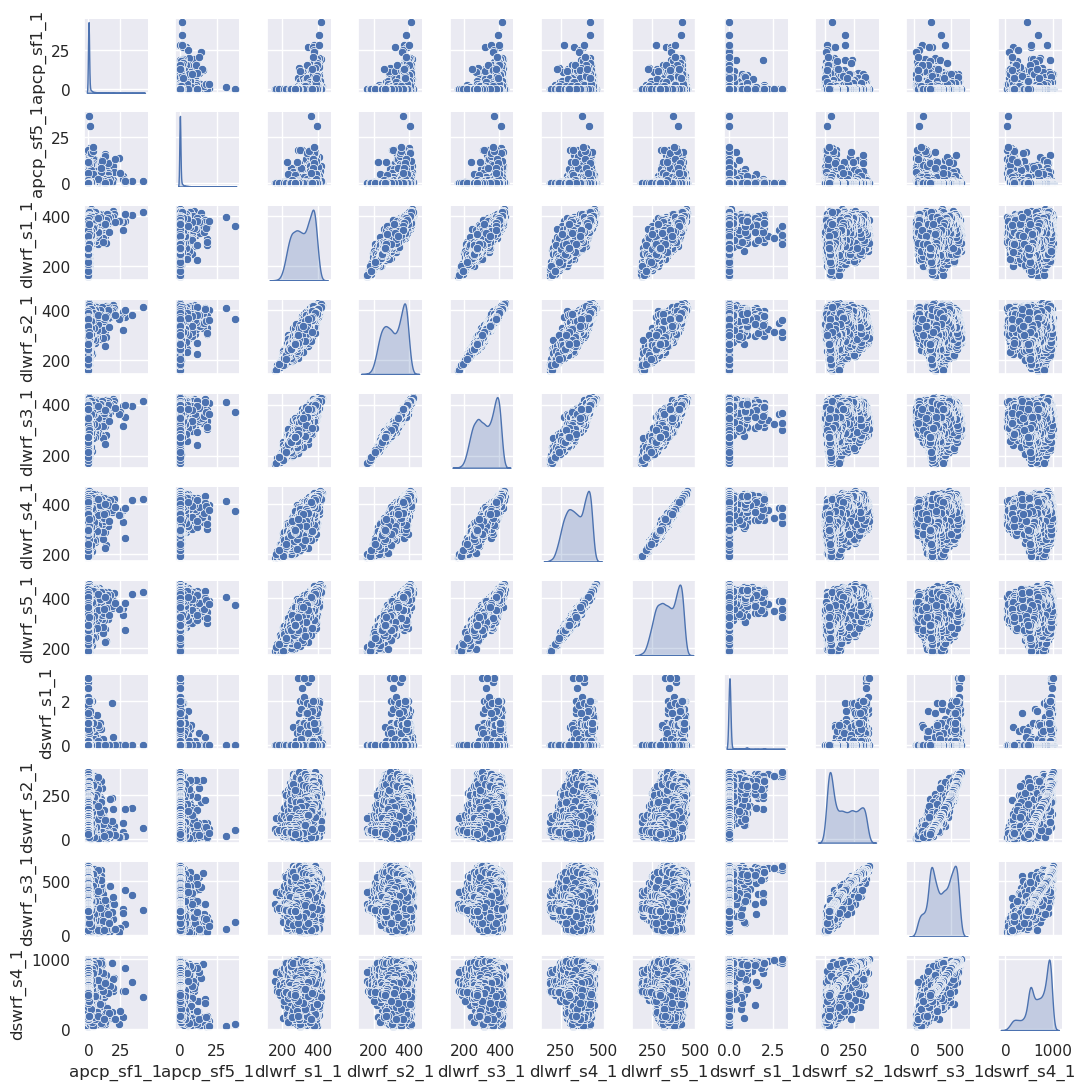

In [22]:
sns.set()
columns = []

# We get all the columns -- lot of time (76x76)
# for column in disp_df:
#     columns.append(column)
# print(columns)

# TODO: METER AQUI LAS COLUMNAS QUE CREAMOS QUE TIENEN MUCHA CORRELACION
columns = ['apcp_sf1_1', 'apcp_sf5_1', 'dlwrf_s1_1', 'dlwrf_s2_1', 'dlwrf_s3_1', 'dlwrf_s4_1', 'dlwrf_s5_1', 'dswrf_s1_1', 'dswrf_s2_1', 'dswrf_s3_1', 'dswrf_s4_1']

sns.pairplot(disp_df[columns], size = 1 ,kind ='scatter',diag_kind='kde')
plt.show()


In [23]:
list_of_attributes = disp_df.columns.values.tolist()
tuplas_correlacion = []
for column in correlation: 
    for value in correlation[column][mask].sort_values(ascending = False):
        if value > 0.95:
            locals()[column].append(correlation[column][mask].sort_values(ascending = False).head(5).index.tolist())

KeyError: 'salida'

In [ ]:
correlation = disp_df.corr()
correlation = abs(correlation)
for column in disp_df:
    
    mask = correlation[column] > 0.9
    correlation = correlation[column][mask]
    print(correlation)
    #print(correlation[column].sort_values(ascending = False).head(5),'\n')
    for i in correlation[column]: 
        locals()["index" + str(column)]  = pd.array().append(correlation[column].find(correlation[column][i]))
        #We add all the indexes of the correlation that are above 0.9
    locals()["index" + str(column)] 

apcp_sf1_1    1.0
Name: apcp_sf1_1, dtype: float64


TypeError: 'numpy.float64' object is not iterable

IndexError: Inconsistent shape between the condition and the input (got (1, 1) and (1,))

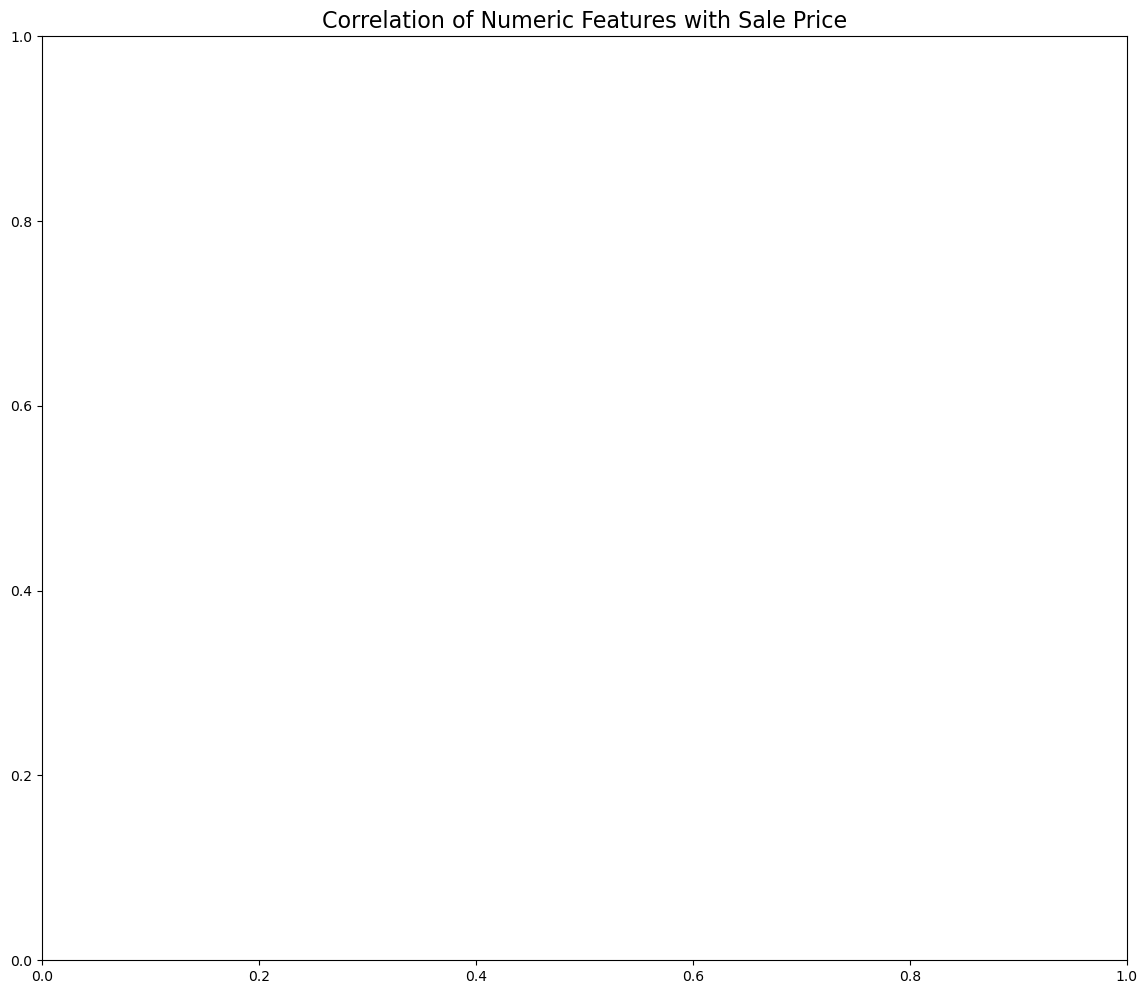

In [ ]:
f , ax = plt.subplots(figsize = (14,12))
plt.title('Correlation of Numeric Features with Sale Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)

In [ ]:
k= 11
cols = correlation.nsmallest(k, 'salida')['salida'].index
print(cols)
cm = np.corrcoef(disp_df[cols].values.T)
f , ax = plt.subplots(figsize = (14,12))
sns.heatmap(cm, vmax=.8, linewidths=0.01,square=True,annot=True,cmap='viridis',
            linecolor="white",xticklabels = cols.values ,annot_kws = {'size':12},yticklabels = cols.values)

ValueError: keep must be either "first", "last" or "all"